In [1]:
from wavenet_model_modified import * 
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)
torch.cuda.empty_cache()



# hsn = load_dataset('DBD-research-group/BirdSet', 'HSN')
hsn = h5py.File('../test_24k.hdf5', 'r')
seq_len_segment = 2 ** 15
mu = 128
batch_size = 8
# dataset = BirdsetDataset(hsn, seq_len_segment, mu)
# dataset = SnippetDatasetHDF(hsn)
dataset = SnippetDatasetHSN(hsn, seq_len_segment, mu)
# hsn.close()
# subset_indices = random.sample(range(len(hsn['train'])), int(len(hsn['train']) * subset_percentage))
# hsn = hsn['train'].select(subset_indices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = mu
kernel_size = 1
model = Wavenet(dilation_depth, n_blocks, n_dilation_channels, n_residual_channels, n_skip_channels, n_category,
                kernel_size, seq_len_segment=seq_len_segment)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 6
model.train()

oneHot = OneHot(n_category)

for epoch in range(epochs):
    for i, inputs in enumerate(dataloader):

        inputs = inputs.to(device)
        inputs = inputs.contiguous()
        targets = oneHot(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        # batch_size, seq_len, num_classes = outputs.size()
        # outputs = outputs.contiguous().view(-1, num_classes)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # if epoch % 10 == 0:
        print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {loss.item() / 10:.4f}')

print('saving model')
torch.save(model.state_dict(), 'wavenet_model.pth')





cuda


  0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 1, Batch 1] loss: 0.4712
[Epoch 1, Batch 2] loss: 0.4484
[Epoch 1, Batch 3] loss: 0.4277
[Epoch 1, Batch 4] loss: 0.4062
[Epoch 1, Batch 5] loss: 0.3839
[Epoch 2, Batch 1] loss: 0.3586
[Epoch 2, Batch 2] loss: 0.3287
[Epoch 2, Batch 3] loss: 0.2939
[Epoch 2, Batch 4] loss: 0.2542
[Epoch 2, Batch 5] loss: 0.2091
[Epoch 3, Batch 1] loss: 0.1594
[Epoch 3, Batch 2] loss: 0.1090
[Epoch 3, Batch 3] loss: 0.0643
[Epoch 3, Batch 4] loss: 0.0315
[Epoch 3, Batch 5] loss: 0.0130
[Epoch 4, Batch 1] loss: 0.0049
[Epoch 4, Batch 2] loss: 0.0018
[Epoch 4, Batch 3] loss: 0.0006
[Epoch 4, Batch 4] loss: 0.0002
[Epoch 4, Batch 5] loss: 0.0001
[Epoch 5, Batch 1] loss: 0.0000
[Epoch 5, Batch 2] loss: 0.0000
[Epoch 5, Batch 3] loss: 0.0000
[Epoch 5, Batch 4] loss: 0.0000
[Epoch 5, Batch 5] loss: 0.0000
[Epoch 6, Batch 1] loss: 0.0000
[Epoch 6, Batch 2] loss: 0.0000
[Epoch 6, Batch 3] loss: 0.0000
[Epoch 6, Batch 4] loss: 0.0000
[Epoch 6, Batch 5] loss: 0.0000
saving model


  0%|          | 0/84 [00:00<?, ?it/s]

model loaded


  0%|          | 0/20 [00:00<?, ?it/s]

21
[[-0.9634021  -0.96340406 -0.9633649  ... -0.9634047  -0.9634047
  -0.9634047 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


"\nseed_length = mu - 30\nseed_input = torch.randint(0, mu, (seed_length,)).to(device)\nseed_input = seed_input.float().to(device)\n\nnum_samples = 100\ngenerated_sequence = model.generate(seed_input, num_samples=10)\ngenerated_waveform = inv_mulaw_quantize(torch.tensor(generated_sequence).to(device), quantization_channels=mu)\nprint(generated_sequence)\n\ngenerated_waveform = generated_waveform.cpu()\ntorchaudio.save('generated_sample.wav', generated_waveform.unsqueeze(0), 24000) \n"

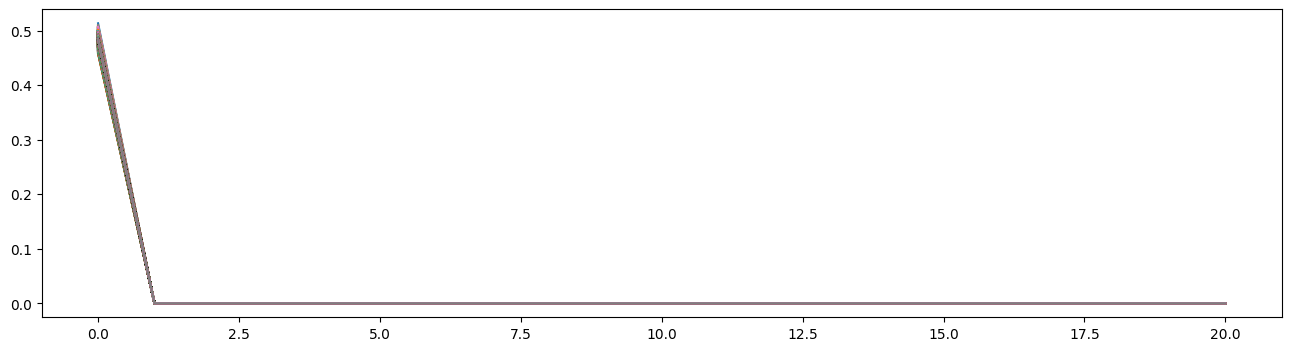

In [4]:
from matplotlib import pyplot as plt
from wavenet_model_modified import * 

hsn = h5py.File('../test_24k.hdf5', 'r')
subset_percentage = 0.5
seq_len_segment = 2 ** 15
mu = 128
batch_size = 8
dataset = SnippetDatasetHSN(hsn, seq_len_segment, mu)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

seq_len_segment = 2 ** 15
mu = 128
batch_size = 8
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = mu
kernel_size = 1
model = Wavenet(dilation_depth, n_blocks, n_dilation_channels, n_residual_channels, n_skip_channels, n_category,
                kernel_size, seq_len_segment=seq_len_segment)
model.load_state_dict(torch.load('wavenet_model.pth', weights_only=False))
model.eval()
print('model loaded')
model.to(device)

import torch
import torchaudio

# input_data = data_generation_sample(data[0], mu=128, seq_len=len(data[0]),device = device)
# print(input_data.shape)   
generated_audio = model.generate(dataset.data[0].unsqueeze(0), num_samples=20)
print(len(generated_audio))

plt.figure(figsize=[16, 4])
plt.plot(generated_audio)

y = np.array(generated_audio)
y = inv_mulaw_quantize(y, 128)
print(y)
generated_waveform = torch.tensor(y).float().to(device)
generated_waveform = generated_waveform.cpu()
torchaudio.save('generated_sample.wav', generated_waveform, 16000) 

'''
seed_length = mu - 30
seed_input = torch.randint(0, mu, (seed_length,)).to(device)
seed_input = seed_input.float().to(device)

num_samples = 100
generated_sequence = model.generate(seed_input, num_samples=10)
generated_waveform = inv_mulaw_quantize(torch.tensor(generated_sequence).to(device), quantization_channels=mu)
print(generated_sequence)

generated_waveform = generated_waveform.cpu()
torchaudio.save('generated_sample.wav', generated_waveform.unsqueeze(0), 24000) 
'''